In [1]:
from glob import glob
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [2]:
from model.dncnn import DnCNN
from utils.train_utils import batch_PSNR, weights_init_orthogonal
import torch.nn as nn
import torch.optim as optim

In [3]:
from torch.utils.data import DataLoader, random_split
from mydataset import MyDataset
from torchvision import transforms
import my_trans
from my_earlystop import EarlyStopper

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
device = "cpu"

In [5]:
data_root_dir = "E:/DAS_noisy_pairs_50Hz"
data_fp = glob(os.path.join(data_root_dir, "*.npy"))
data_fp[:5]

['E:/DAS_noisy_pairs_50Hz\\1115_1107_StrainRate_20231115T112107+0800_14.npy',
 'E:/DAS_noisy_pairs_50Hz\\1115_1107_StrainRate_20231115T112207+0800_15.npy',
 'E:/DAS_noisy_pairs_50Hz\\1115_1107_StrainRate_20231115T112307+0800_16.npy',
 'E:/DAS_noisy_pairs_50Hz\\1115_1107_StrainRate_20231115T112407+0800_17.npy',
 'E:/DAS_noisy_pairs_50Hz\\1115_1107_StrainRate_20231115T112507+0800_18.npy']

In [ ]:
arr = np.load(data_fp[1])
arr.shape

In [ ]:
print(np.mean(abs(arr[:,:,0]-arr[:,:,1])))
fig = plt.figure()
fig.add_subplot(311)
plt.imshow(arr[:,:,0], cmap='seismic',vmin=-1.,vmax=1.,aspect='auto')
plt.xticks([])
fig.add_subplot(312)
plt.imshow(arr[:,:,1], cmap='seismic',vmin=-1.,vmax=1.,aspect='auto')
plt.xticks([])
fig.add_subplot(313)
plt.imshow(abs(arr[:,:,0]-arr[:,:,1]), cmap='inferno',vmin=0.,vmax=2.,aspect='auto')

In [6]:
def tensor2npy(tensor:torch.Tensor):
    if tensor.dim() == 3:
        tensor = tensor.permute(1,2,0)

    elif tensor.dim() == 4:
        tensor.permute(0,2,3,1)

    return tensor.cpu().detach().numpy()

In [7]:
CROP_SIZE = (256,256)
BATCH_SIZE = 32
EPOCHS = 200
trans = transforms.Compose([
    transforms.ToTensor(),
    my_trans.RandomCropWithinBounds(crop_size=CROP_SIZE),
    my_trans.ChannelNorm(),
    my_trans.SampleClamp(6.0),
    my_trans.LinearNorm1()
])

dataset = MyDataset(data_root_dir, crop_size=CROP_SIZE, transform=trans)
train_ds, val_ds, test_ds = random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_ds, batch_size=16)
test_dataloader = DataLoader(test_ds, batch_size=16)
print(len(train_ds), len(val_ds), len(test_ds))

1589 198 198


In [ ]:
# training dataloader test
for idx, (x1,x2) in enumerate(train_dataloader):
    print("x1: ", x1.shape)
    print("x2: ", x2.shape)
    if idx == 1:
        break

In [ ]:
arr1 = tensor2npy(x1)
arr2 = tensor2npy(x2)
arr1 = arr1.squeeze()
arr2 = arr2.squeeze()
arr1.shape, arr2.shape

In [ ]:
print(np.mean(abs(arr1[0]-arr2[0])))
fig = plt.figure()
fig.add_subplot(311)
plt.imshow(arr1[0], cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
plt.xticks([])
fig.add_subplot(312)
plt.imshow(arr2[0], cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
plt.xticks([])
fig.add_subplot(313)
plt.imshow(abs(arr1[0]-arr2[0]), cmap='inferno_r',vmin=0.,vmax=0.1,aspect='auto')

In [ ]:
def save_checkpoint(model, optimizer, epoch_num, checkpoint_dir):
	checkpoint = {'epoch_num' : epoch_num, 'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict()}
	torch.save(checkpoint, checkpoint_dir)

In [8]:
num_channels = 1
model_save_dir = "my_results"
chkpt_save_dir = "my_results/checkpoints"

In [9]:
model = DnCNN(channels=num_channels, num_of_layers=9)
model.apply(weights_init_orthogonal)
model.to(device)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), str

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='sum')
lr_schedule = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
early_stop = EarlyStopper(patience=10)

In [ ]:
# training loop
for epoch in range(EPOCHS):
	n_steps = 0
	tr_loss_list = []
	val_loss_list = []
	tr_loss = 0
	val_loss = 0
	# train
	for i, (noisy1, noisy2) in enumerate(train_dataloader):
		# training step
		model.train()
		model.zero_grad()
		optimizer.zero_grad()

		noisy1, noisy2 = noisy1.to(device), noisy2.to(device)

		denoised1 = model(noisy1)
		loss1 = criterion(denoised1, noisy2) / (noisy1.size()[0]*2)
		
		denoised2 = model(noisy2)
		loss2 = criterion(denoised2, noisy1) / (noisy2.size()[0]*2)
		loss = (loss1+loss2)/2

		loss.backward()
		optimizer.step()
		tr_loss += loss.item()
		
		n_steps += 1
	tr_loss /= n_steps
	tr_loss_list.append(tr_loss)
	lr_schedule.step()
	cur_lr = lr_schedule.get_last_lr()[-1]
	

	model.eval()
	n_steps = 0
	# validate
	with torch.no_grad():
		for (noisy1, noisy2) in val_dataloader:
			noisy1, noisy2 = noisy1.to(device), noisy2.to(device)

			denoised = model(noisy1)
			loss = criterion(denoised, noisy2) / (noisy1.size()[0]*2)
			denoised = torch.clamp(denoised, -1., 1.)

			val_loss += loss.item()
			n_steps += 1

		val_loss /= n_steps
		val_loss_list.append(val_loss)


	print(f"Epoch: {epoch+1} | tr_loss: {tr_loss:.4f} | val_loss: {val_loss:.4f} | lr: {cur_lr:.2e}")

    # save model chkpt
	if epoch % 10 == 0:
		save_checkpoint(model, optimizer, epoch, os.path.join(chkpt_save_dir, 'epoch_{}_dncnn_model_net.pth'.format(epoch)))
	
	# save model weights
	if early_stop(val_loss):
		torch.save(model.state_dict(), os.path.join(model_save_dir, "dncnn_best.pt"))
		break

In [ ]:
# save history
tr_loss_arr = np.array(tr_loss_list)
val_loss_arr = np.array(val_loss_list)
np.save(os.path.join(model_save_dir, "tr_loss.npy"), tr_loss_arr)
np.save(os.path.join(model_save_dir, "val_loss.npy"), val_loss_arr)

In [ ]:
plt.clf()
plt.plot(tr_loss_arr, color='b')
plt.plot(val_loss_arr, color='r')


In [11]:
model = DnCNN(channels=1, num_of_layers=9)
model.load_state_dict(torch.load("my_results\dncnn_best.pt"))
model.to(device)

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size=(3, 3), str

In [45]:
# total number of parameters
total_params = sum(p.numel() for p in model.parameters())
total_params

260160

In [53]:
tr_loss = []
val_loss = []
with open("my_results/log.txt", 'r') as f:
    for line in f.readlines():
        txt = line.split("|")
        tr_loss.append(float(txt[1].split(":")[-1].strip())) # tr_loss
        val_loss.append(float(txt[2].split(":")[-1].strip())) # val_loss

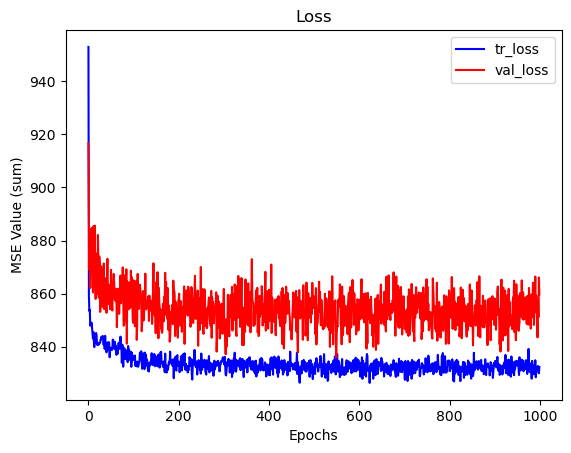

In [55]:
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Value (sum)")
plt.plot(tr_loss, 'b', label='tr_loss')
plt.plot(val_loss, 'r', label='val_loss')
plt.legend()
plt.savefig(os.path.join("my_results","plots","loss.png"))


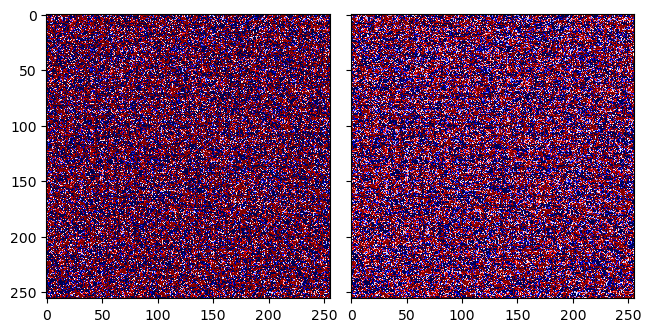

In [24]:
with torch.inference_mode():
    t = np.random.random((512,512,1)).astype(np.float32)
    t = trans(t).unsqueeze(0).to(device)
    y = model(t)
    y = y.squeeze().cpu().detach().numpy()
    t = t.squeeze().cpu().detach().numpy()

fig, axes = plt.subplots(1,2, sharey=True, constrained_layout=True)
axes[0].imshow(t, cmap='seismic', vmin=-0.2, vmax=0.2)
axes[1].imshow(y, cmap='seismic', vmin=-0.2, vmax=0.2)

In [25]:
with torch.inference_mode():
    for idx, (n1,n2) in enumerate(test_dataloader):
        n1, n2 = n1.to(device), n2.to(device)
        d1 = model(n1).cpu().detach()
        d2 = model(n2).cpu().detach()
        break


In [26]:
n1 = n1.cpu().detach().squeeze().numpy()
n2 = n2.cpu().detach().squeeze().numpy()
print(n1.shape, n2.shape)

(16, 256, 256) (16, 256, 256)


In [27]:
d1 = d1.numpy()
d2 = d2.numpy()
print(d1.shape, d2.shape)

(16, 1, 256, 256) (16, 1, 256, 256)


0.035543203
0.16964799


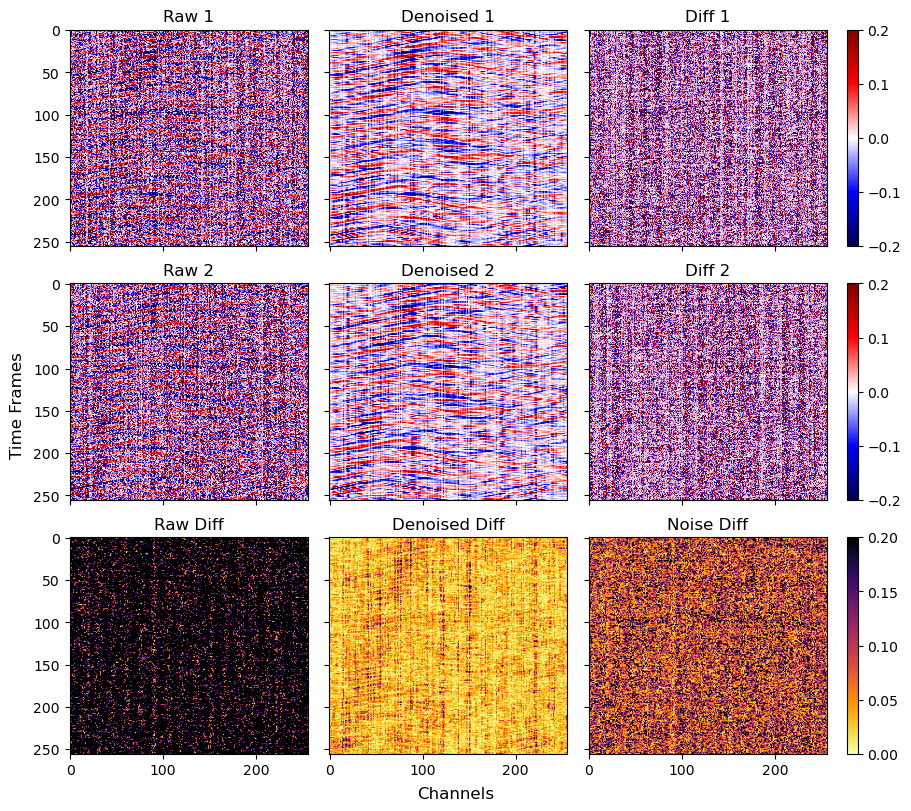

In [44]:
print(np.mean(abs(d1[0]-d2[0]).squeeze()))
print(np.mean(abs(n1[0]-n2[0]).squeeze()))

fig, ax = plt.subplots(3,3,figsize=(9,8), sharex=True, sharey=True, constrained_layout=True)
fig.supxlabel("Channels")
fig.supylabel("Time Frames")

ax[0,0].set_title("Raw 1")
im = ax[0,0].imshow(n1[0].squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
# plt.colorbar(im, ax=ax[0,0])

ax[1,0].set_title("Raw 2")
im = ax[1,0].imshow(n2[0].squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
# plt.colorbar(im, ax=ax[1,0])

ax[2,0].set_title("Raw Diff")
im = ax[2,0].imshow(abs(n1[0]-n2[0]).squeeze(), cmap='inferno_r',vmin=0.,vmax=0.1,aspect='auto')
# plt.colorbar(im, ax=ax[2,0])

ax[0,1].set_title("Denoised 1")
im = ax[0,1].imshow(d1[0].squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
# plt.colorbar(im, ax=ax[0,1])

ax[1,1].set_title("Denoised 2")
im = ax[1,1].imshow(d2[0].squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
# plt.colorbar(im, ax=ax[1,1])

ax[2,1].set_title("Denoised Diff")
im = ax[2,1].imshow(abs(d1[0]-d2[0]).squeeze(), cmap='inferno_r',vmin=0.,vmax=0.2,aspect='auto')
# plt.colorbar(im, ax=ax[2,1])

ax[0,2].set_title("Diff 1")
im = ax[0,2].imshow((n1[0]-d1[0]).squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
plt.colorbar(im, ax=ax[0,2])

ax[1,2].set_title("Diff 2")
im = ax[1,2].imshow((n2[0]-d2[0]).squeeze(), cmap='seismic',vmin=-0.2,vmax=0.2,aspect='auto')
plt.colorbar(im, ax=ax[1,2])

ax[2,2].set_title("Noise Diff")
im = ax[2,2].imshow(abs(abs(n1[0]-d1[0])-abs(n2[0]-d2[0])).squeeze(), cmap='inferno_r',vmin=0.,vmax=0.2,aspect='auto')
plt.colorbar(im, ax=ax[2,2])

plt.savefig(os.path.join("my_results","plots","test_denoised.png"))

NoiseFlow

In [14]:
from noise2noiseflow.model.noise_flow import NoiseFlow

In [16]:
def init_params():
    npcam = 3
    c_i = 1.0
    beta1_i = -5.0 / c_i
    beta2_i = 0.0
    gain_params_i = np.ndarray([5])
    gain_params_i[:] = -5.0 / c_i
    cam_params_i = np.ndarray([npcam, 5])
    cam_params_i[:, :] = 1.0
    return (c_i, beta1_i, beta2_i, gain_params_i, cam_params_i)

In [19]:
x_shape = (2,256,256)
noiseflow = NoiseFlow(
    x_shape=x_shape,
    arch='unc|gain|unc|gain|unc|gain|unc',
    flow_permutation=1,
    param_inits=init_params(),
    lu_decomp=False,
)
noiseflow.model.eval()
noiseflow = noiseflow.to(device)

|-Conv2d1x1
|-AffineCoupling
|-Gain
|-Conv2d1x1
|-AffineCoupling
|-Gain
|-Conv2d1x1
|-AffineCoupling
|-Gain
|-Conv2d1x1
|-AffineCoupling


In [20]:
noiseflow.load_state_dict(torch.load("my_results/noiseflow_best.pt"))

<All keys matched successfully>

In [ ]:
with torch.inference_mode():
    x = torch.randn((2,2,256,256), device=device)
    z, y = noiseflow(x)
    print(z.shape)
    print(y.shape)

In [ ]:
# Freeze all denoiser layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# training loop
min_val_loss = float('inf')
for epoch in range(EPOCHS):
	n_steps = 0
	tr_loss_list = []
	tr_loss = 0
	# train
	for i, (noisy1, noisy2) in enumerate(train_dataloader):
		# training step
		optimizer.zero_grad()

		noisy1, noisy2 = noisy1.to(device), noisy2.to(device)

		denoised1 = model(noisy1)
		denoised2 = model(noisy2)

		noise1 = noisy1 - denoised2
		noise2 = noisy2 - denoised1

		# since noiseflow model doesn't accpet input shape with (1,256,256)
		noise1 = torch.concat([noise1, noise1], dim=1) 
		noise2 = torch.concat([noise2, noise2], dim=1)

		nll1, _ = noiseflow.loss(noise1)
		nll2, _ = noiseflow.loss(noise2)

		loss = (nll1 + nll2) / 2
		loss.backward()
		optimizer.step()
		tr_loss += loss.item()
		n_steps += 1

	tr_loss /= n_steps
	tr_loss_list.append(tr_loss)
	lr_schedule.step()
	cur_lr = lr_schedule.get_last_lr()[-1]
	
	# validate
	noiseflow.eval()
	n_steps = 0
	val_loss_list = []
	val_loss = 0
	with torch.no_grad():
		for (noisy1, noisy2) in val_dataloader:
			noisy1, noisy2 = noisy1.to(device), noisy2.to(device)

			denoised1 = model(noisy1)
			denoised2 = model(noisy2)

			noise1 = noisy1 - denoised2
			noise2 = noisy2 - denoised1

			# since noiseflow model doesn't accpet input shape with (1,256,256)
			noise1 = torch.concat([noise1, noise1], dim=1) 
			noise2 = torch.concat([noise2, noise2], dim=1)		

			nll1, _ = noiseflow.loss(noise1)
			nll2, _ = noiseflow.loss(noise2)

			loss = (nll1 + nll2) / 2
			val_loss += loss.item()
			n_steps += 1

		val_loss /= n_steps
		val_loss_list.append(val_loss)


	print(f"Epoch: {epoch+1} | tr_loss: {tr_loss:.4f} | val_loss: {val_loss:.4f} | lr: {cur_lr:.2e}")

    # save model chkpt
	if epoch % 20 == 0:
		save_checkpoint(noiseflow, optimizer, epoch, os.path.join(chkpt_save_dir, 'epoch_{}_noiseflow_model_net.pth'.format(epoch)))
	
	# save model weights
	if val_loss < min_val_loss:
		min_val_loss = val_loss
		torch.save(noiseflow.state_dict(), os.path.join(model_save_dir, "noiseflow_best.pt"))

	if early_stop(val_loss):		
		break

In [21]:
x1, x2 = next(iter(test_dataloader))
x1.shape, x2.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

In [22]:
with torch.inference_mode():
    x1 = x1.to(device)
    x2 = x2.to(device)
    clean1 = model(x1)
    clean2 = model(x2)
    n1 = (x1-clean2)
    n2 = (x2-clean1)
    n1 = torch.concat([n1, n1], dim=1)
    n2 = torch.concat([n2, n2], dim=1)
    y1, _ = noiseflow(n1)
    y2, _ = noiseflow(n2)
n1.shape, y1.shape

(torch.Size([16, 2, 256, 256]), torch.Size([16, 2, 256, 256]))

In [23]:
x1 = x1.permute(0,2,3,1).cpu().detach().numpy()
x2 = x2.permute(0,2,3,1).cpu().detach().numpy()
clean1 = clean1.permute(0,2,3,1).cpu().detach().numpy()
clean2 = clean2.permute(0,2,3,1).cpu().detach().numpy()
y1 = y1.permute(0,2,3,1).cpu().detach().numpy()
y2 = y2.permute(0,2,3,1).cpu().detach().numpy()
n1 = n1.permute(0,2,3,1).cpu().detach().numpy()
n2 = n2.permute(0,2,3,1).cpu().detach().numpy()

In [25]:
diff_raw_denoise = abs(x1 - clean1)
diff_denoise_nf = abs(clean1 - y1)
diff_raw_nf = abs(x1 - y1)
diff_nf = abs(n1-y1)
recover_nf = (n1+y1)
recover_denoise = (n1+clean1)
diff_raw_denoise.shape

(16, 256, 256, 1)

In [ ]:
print(np.min(x1), np.max(x1), np.std(x1))
print(np.min(clean1), np.max(clean1), np.std(clean1))
print(np.min(n1), np.max(n1), np.std(n1))
print(np.min(y1), np.max(y1), np.std(y1))

In [ ]:
print(np.min(diff_raw_denoise), np.max(diff_raw_denoise), np.std(diff_raw_denoise))
print(np.min(diff_denoise_nf), np.max(diff_denoise_nf), np.std(diff_denoise_nf))
print(np.min(diff_nf), np.max(diff_denoise_nf), np.std(diff_nf))

In [ ]:
diff_raw_denoise = abs(x2 - clean2)
diff_denoise_nf = abs(clean2 - y2)
diff_raw_nf = abs(x2 - y2)
diff_nf = abs((x2-clean2)-y2)

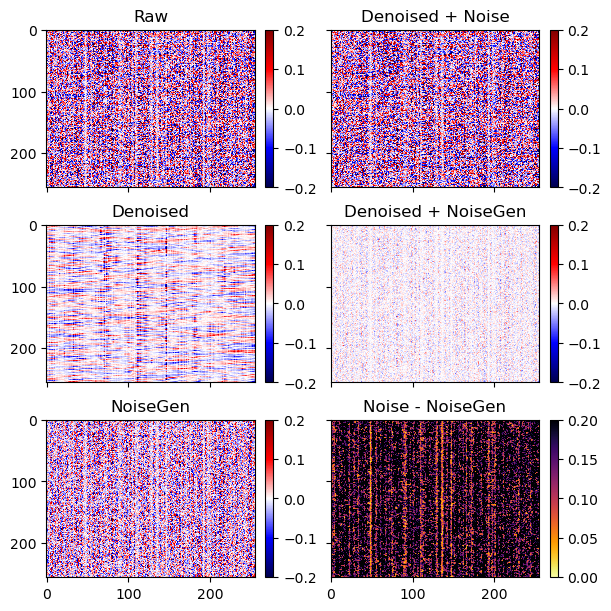

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
axes[0,0].set_title("Raw")
im = axes[0,0].imshow(x1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[0,0])
axes[0,1].set_title("Denoised + Noise")
im = axes[0,1].imshow(recover_denoise[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[0,1])

axes[1,0].set_title("Denoised")
im = axes[1,0].imshow(clean1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[1,0])

axes[1,1].set_title("Denoised + NoiseGen")
im = axes[1,1].imshow(recover_nf[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[1,1])

axes[2,0].set_title("NoiseGen")
im = axes[2,0].imshow(y1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[2,0])

axes[2,1].set_title("Noise - NoiseGen")
im = axes[2,1].imshow(diff_raw_nf[0,:,:,0].squeeze(), cmap='inferno_r', vmin=0., vmax=0.2, aspect='auto')
plt.colorbar(im, ax=axes[2,1])

In [ ]:
plots = np.hstack((n1[0,:,:,0].flatten(),y1[0,:,:,0].flatten()))
bins = np.histogram(plots, bins=100)[1]

In [ ]:
# fig = plt.figure(figsize=(4,8))
# ax = fig.add_subplot(211)
# ax.set_title("Raw DAS")
# ax.hist(x1[0,:,:,0].flatten(), bins=100)

# ax = fig.add_subplot(212)
# ax.set_title("Noises")
plt.hist(x1[0,:,:,0].flatten(), bins=bins, color='orange', alpha=0.8, label='Raw')
plt.hist(n1[0,:,:,0].flatten(), bins=bins, color='g', alpha=0.6, label='Noise')
plt.hist(y1[0,:,:,0].flatten(), bins=bins, color='r', alpha=0.6, label='Gen Noise')
plt.xlim((-1,1))
plt.legend()

In [ ]:
import torch.fft

In [ ]:
def tensorfft2d(tensor):
    assert tensor.dim() == 3
    fft_tensor = torch.fft.fft2(tensor) # dtype=complex64
    fft_tensor = torch.fft.fftshift(fft_tensor)
    fft_tensor = torch.log(torch.abs(fft_tensor)) # dtype=float32
    return fft_tensor

In [ ]:
t = torch.from_numpy(y1[0,:,:,0])
t.shape

In [ ]:
x1fft = tensorfft2d(t.unsqueeze(0))
x1fft.shape

In [ ]:
n1fft = tensorfft2d(t.unsqueeze(0))
n1fft.shape

In [ ]:
y1fft = tensorfft2d(t.unsqueeze(0))
y1fft.shape

In [ ]:
fig = plt.figure(figsize=(3,6))
ax = fig.add_subplot(311)
ax.set_title("Raw")
im = ax.imshow(x1fft.squeeze().detach().numpy(), cmap='gray', vmin=0, aspect='auto')
plt.colorbar(im, ax=ax)

ax = fig.add_subplot(312)
ax.set_title("Noise")
im = ax.imshow(n1fft.squeeze().detach().numpy(), cmap='gray', vmin=0, aspect='auto')
plt.colorbar(im, ax=ax)

ax = fig.add_subplot(313)
ax.set_title("NoiseGen")
im = ax.imshow(y1fft.squeeze().detach().numpy(), cmap='gray', vmin=0, aspect='auto')
plt.colorbar(im, ax=ax)

plt.tight_layout()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(311)
ax.set_title("Raw")
im = ax.imshow(x1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
ax.set_xticks([])
plt.colorbar(im, ax=ax)
ax = fig.add_subplot(312)
ax.set_title("Clean")
im = ax.imshow(clean1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.2, vmax=0.2, aspect='auto')
ax.set_xticks([])
plt.colorbar(im, ax=ax)
ax = fig.add_subplot(313)
ax.set_title("Gen Noise")
im = ax.imshow(n1[0,:,:,0].squeeze(), cmap='seismic', vmin=-0.01, vmax=0.01, aspect='auto')
plt.colorbar(im, ax=ax)

In [ ]:
clean1.shape

In [ ]:
plt.imshow(clean1[0], cmap='seismic', vmin=-1, vmax=1., aspect='auto')

In [ ]:
x = torch.from_numpy(clean1).permute(0,3,1,2)
x = torch.concat([x,x], dim=1)
x = x.to(device)
# y = noiseflow.sample(clean=x)
y, _ = noiseflow(x)
y.shape

In [ ]:
y_plot = y.permute(0,2,3,1).cpu().detach().numpy()
plt.imshow(y_plot[0,:,:,0], cmap='seismic', vmin=-0.1, vmax=0.1, aspect='auto')